In [1]:
import os
import requests
import dotenv
import time
import numpy as np
import pandas as pd
import alpaca_trade_api as alpaca_api
import krakenex
import pykrakenapi
import pandas_montecarlo

%matplotlib inline

In [2]:
def random_portfolios_generator(tickers, n):
    random_portfolios = pd.DataFrame({'ticker':tickers})
    for n in range(0, n):
        random_portfolios[f'random weights {n+1}'] = [np.random.rand() for i in range (0, len(tickers))]
        random_portfolios[f'random weights {n+1}'] = random_portfolios[f'random weights {n+1}'] / sum(random_portfolios[f'random weights {n+1}'])
    return(random_portfolios)

In [3]:
dotenv.load_dotenv()

True

In [4]:
alpaca_api_key = os.getenv('alpaca_api_key')
alpaca_secret_key = os.getenv('alpaca_secret_key')
kraken_api_key = os.getenv('kraken_api_key')
kraken_secret_key = os.getenv('kraken_secret_key')

print(type(alpaca_api_key))
print(type(alpaca_secret_key))
print(type(kraken_api_key))
print(type(kraken_secret_key))

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


In [5]:
alpaca = alpaca_api.REST(alpaca_api_key, alpaca_secret_key, api_version="v2")

faangm_tickers =  ['AAPL',  'ABNB', 'AMZN', 'FB', 'GOOG', 'LYFT', 'MSFT', 'NFLX', 'UBER']
start = pd.Timestamp('2015-12-01', tz='America/New_York').isoformat()

faangm_original = alpaca.get_bars(faangm_tickers, alpaca_api.TimeFrame.Day, start = start).df
faangm_original

,open,high,low,close,volume,trade_count,vwap,symbol
timestamp,,,,,,,,
2015-12-01 05:00:00+00:00,118.73,118.810,116.860,117.34,34852374,187129,117.756760,AAPL
2015-12-02 05:00:00+00:00,117.00,118.110,116.080,116.28,33385643,180616,117.151198,AAPL
2015-12-03 05:00:00+00:00,116.55,116.790,114.220,115.20,41560785,245330,115.434888,AAPL
2015-12-04 05:00:00+00:00,115.20,119.250,115.110,119.03,57776977,307788,118.187290,AAPL
2015-12-07 05:00:00+00:00,118.98,119.860,117.810,118.28,32080754,190809,118.509111,AAPL
...,...,...,...,...,...,...,...,...
2022-04-04 04:00:00+00:00,36.40,36.930,36.215,36.51,20197208,146275,36.621379,UBER
2022-04-05 04:00:00+00:00,36.43,36.610,34.720,34.96,20987999,153337,35.188058,UBER
2022-04-06 04:00:00+00:00,33.82,34.000,32.550,33.41,29163174,203021,33.287397,UBER


In [6]:
faangm = faangm_original.drop(['open', 'high', 'low', 'volume', 'trade_count', 'vwap'], axis = 1).pivot(columns = 'symbol')
faangm.index = faangm.index.date
faangm.columns = faangm_tickers
faangm

,AAPL,ABNB,AMZN,FB,GOOG,LYFT,MSFT,NFLX,UBER
2015-12-01,117.34,NaN,679.06,107.12,767.04,NaN,55.22,125.37,NaN
2015-12-02,116.28,NaN,676.01,106.07,762.38,NaN,55.21,128.93,NaN
2015-12-03,115.20,NaN,666.25,104.38,752.54,NaN,54.20,126.81,NaN
2015-12-04,119.03,NaN,672.64,106.18,766.81,NaN,55.91,130.93,NaN
2015-12-07,118.28,NaN,669.83,105.61,763.25,NaN,55.81,125.36,NaN
...,...,...,...,...,...,...,...,...,...
2022-04-04,178.44,177.02,3366.93,233.89,2872.85,38.96,314.97,391.50,36.51
2022-04-05,175.06,171.21,3281.10,231.84,2821.26,37.15,310.88,380.15,34.96
2022-04-06,171.59,164.66,3175.12,223.30,2743.52,36.08,299.50,368.35,33.41
2022-04-07,172.14,165.91,3155.69,222.95,2729.30,34.61,301.37,362.15,32.27


In [12]:
# Market capitalization data in trillions of dollars, sourced from Trading View on April 6, 2022.

faangm_caps_list = [2.804, 0.105855, 1.616, 0.60781, 1.81, 0.012576, 2.245, 0.163534, 0.065299]
faangm_cap_portfolio = pd.DataFrame({'tickers':faangm_tickers, 'market cap weights':[market_cap / sum(faangm_caps_list) for market_cap in faangm_caps_list]}).set_index('tickers')
faangm_cap_portfolio

,market cap weights
tickers,
AAPL,0.297347
ABNB,0.011225
AMZN,0.171367
FB,0.064454
GOOG,0.191939
LYFT,0.001334
MSFT,0.238068
NFLX,0.017342
UBER,0.006925


In [13]:
faangm_cap_daily_returns = faangm.pct_change().fillna(0.0).dot(faangm_cap_portfolio)
faangm_cap_daily_returns.columns = ['faangm']
faangm_cap_daily_returns

,faangm
2015-12-01,0.000000
2015-12-02,-0.004804
2015-12-03,-0.013380
2015-12-04,0.024355
2015-12-07,-0.004990
...,...
2022-04-04,0.024182
2022-04-05,-0.018331
2022-04-06,-0.029120
2022-04-07,-0.000202


In [14]:
random_faangm_portfolios = random_portfolios_generator(faangm_tickers, 10)
random_faangm_portfolios

,ticker,random weights 1,random weights 2,random weights 3,random weights 4,random weights 5,random weights 6,random weights 7,random weights 8,random weights 9,random weights 10
0,AAPL,0.178619,0.087034,0.162479,0.042630,0.169465,0.214386,0.175003,0.021781,0.118800,0.159407
1,ABNB,0.099588,0.088883,0.120512,0.056481,0.132233,0.234235,0.014044,0.032658,0.135327,0.156505
2,AMZN,0.069866,0.035141,0.102350,0.080773,0.176921,0.023161,0.216583,0.167690,0.028552,0.028192
3,FB,0.054740,0.218320,0.111975,0.003712,0.005959,0.001835,0.027191,0.067686,0.173582,0.177264
4,GOOG,0.166554,0.073599,0.161151,0.224089,0.024996,0.186947,0.085432,0.004439,0.099674,0.002261
5,LYFT,0.070348,0.100010,0.127831,0.149578,0.040312,0.028270,0.150515,0.223020,0.089311,0.111937
6,MSFT,0.113962,0.041425,0.021241,0.146400,0.142818,0.276602,0.171286,0.231474,0.045425,0.054126
7,NFLX,0.156408,0.135972,0.053165,0.198044,0.221982,0.005677,0.119674,0.012525,0.130466,0.115734
8,UBER,0.089915,0.219615,0.139296,0.098293,0.085314,0.028887,0.040273,0.238728,0.178862,0.194575


In [15]:
random_faangm_daily_returns_list = []
for n in range(0, (len(random_faangm_portfolios.columns) - 1)):
        random_faangm_daily_returns_list.append(faangm.pct_change().dot(list(random_faangm_portfolios.loc[:, f'random weights {n + 1}'])))

random_faangm_daily_returns = pd.concat(random_faangm_daily_returns_list, axis = 'columns', join = 'inner')

for n in range(0, (len(random_faangm_portfolios.columns) - 1)):
        random_faangm_daily_returns = random_faangm_daily_returns.rename(columns = {n: f'random faangm portfolio {n + 1}'})

random_faangm_daily_returns

,random faangm portfolio 1,random faangm portfolio 2,random faangm portfolio 3,random faangm portfolio 4,random faangm portfolio 5,random faangm portfolio 6,random faangm portfolio 7,random faangm portfolio 8,random faangm portfolio 9,random faangm portfolio 10
2015-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-04-04,0.027853,0.029817,0.027373,0.028874,0.029055,0.021833,0.028905,0.025815,0.028978,0.029068
2022-04-05,-0.025003,-0.027147,-0.027187,-0.027542,-0.026346,-0.022009,-0.025466,-0.030297,-0.026846,-0.027988
2022-04-06,-0.031252,-0.034685,-0.031988,-0.032099,-0.032103,-0.031574,-0.030463,-0.035583,-0.033810,-0.034074
2022-04-07,-0.007903,-0.013583,-0.010925,-0.012964,-0.007073,0.000846,-0.009595,-0.016835,-0.011210,-0.011573


In [16]:
faangm_daily_returns = pd.concat([faangm_cap_daily_returns, random_faangm_daily_returns], axis = 1, join = 'inner')
faangm_daily_returns

,faangm,random faangm portfolio 1,random faangm portfolio 2,random faangm portfolio 3,random faangm portfolio 4,random faangm portfolio 5,random faangm portfolio 6,random faangm portfolio 7,random faangm portfolio 8,random faangm portfolio 9,random faangm portfolio 10
2015-12-01,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-02,-0.004804,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-03,-0.013380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-04,0.024355,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-07,-0.004990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2022-04-04,0.024182,0.027853,0.029817,0.027373,0.028874,0.029055,0.021833,0.028905,0.025815,0.028978,0.029068
2022-04-05,-0.018331,-0.025003,-0.027147,-0.027187,-0.027542,-0.026346,-0.022009,-0.025466,-0.030297,-0.026846,-0.027988
2022-04-06,-0.029120,-0.031252,-0.034685,-0.031988,-0.032099,-0.032103,-0.031574,-0.030463,-0.035583,-0.033810,-0.034074
2022-04-07,-0.000202,-0.007903,-0.013583,-0.010925,-0.012964,-0.007073,0.000846,-0.009595,-0.016835,-0.011210,-0.011573


In [17]:
faangm_daily_returns.corr()

,faangm,random faangm portfolio 1,random faangm portfolio 2,random faangm portfolio 3,random faangm portfolio 4,random faangm portfolio 5,random faangm portfolio 6,random faangm portfolio 7,random faangm portfolio 8,random faangm portfolio 9,random faangm portfolio 10
faangm,1.000000,0.906601,0.806005,0.840829,0.850644,0.881309,0.871283,0.918516,0.744442,0.821682,0.789721
random faangm portfolio 1,0.906601,1.000000,0.962417,0.973856,0.981545,0.984554,0.930509,0.977769,0.909709,0.975364,0.960508
random faangm portfolio 2,0.806005,0.962417,1.000000,0.981838,0.960507,0.934930,0.859850,0.936024,0.956768,0.994997,0.989743
random faangm portfolio 3,0.840829,0.973856,0.981838,1.000000,0.963029,0.944348,0.920610,0.952400,0.961625,0.990740,0.988632
random faangm portfolio 4,0.850644,0.981545,0.960507,0.963029,1.000000,0.961937,0.873347,0.975792,0.938729,0.963440,0.947353
random faangm portfolio 5,0.881309,0.984554,0.934930,0.944348,0.961937,1.000000,0.913010,0.964936,0.878505,0.952093,0.940931
random faangm portfolio 6,0.871283,0.930509,0.859850,0.920610,0.873347,0.913010,1.000000,0.877514,0.817288,0.902503,0.898331
random faangm portfolio 7,0.918516,0.977769,0.936024,0.952400,0.975792,0.964936,0.877514,1.000000,0.920421,0.939725,0.924072
random faangm portfolio 8,0.744442,0.909709,0.956768,0.961625,0.938729,0.878505,0.817288,0.920421,1.000000,0.947812,0.953695
random faangm portfolio 9,0.821682,0.975364,0.994997,0.990740,0.963440,0.952093,0.902503,0.939725,0.947812,1.000000,0.996106


In [18]:
faangm_daily_returns.loc[:, 'faangm']

2015-12-01    0.000000
2015-12-02   -0.004804
2015-12-03   -0.013380
2015-12-04    0.024355
2015-12-07   -0.004990
                ...   
2022-04-04    0.024182
2022-04-05   -0.018331
2022-04-06   -0.029120
2022-04-07   -0.000202
2022-04-08   -0.014872
Name: faangm, Length: 1601, dtype: float64

In [22]:
faangm_daily_returns

,faangm,random faangm portfolio 1,random faangm portfolio 2,random faangm portfolio 3,random faangm portfolio 4,random faangm portfolio 5,random faangm portfolio 6,random faangm portfolio 7,random faangm portfolio 8,random faangm portfolio 9,random faangm portfolio 10
2015-12-01,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-02,-0.004804,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-03,-0.013380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-04,0.024355,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-07,-0.004990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2022-04-04,0.024182,0.027853,0.029817,0.027373,0.028874,0.029055,0.021833,0.028905,0.025815,0.028978,0.029068
2022-04-05,-0.018331,-0.025003,-0.027147,-0.027187,-0.027542,-0.026346,-0.022009,-0.025466,-0.030297,-0.026846,-0.027988
2022-04-06,-0.029120,-0.031252,-0.034685,-0.031988,-0.032099,-0.032103,-0.031574,-0.030463,-0.035583,-0.033810,-0.034074
2022-04-07,-0.000202,-0.007903,-0.013583,-0.010925,-0.012964,-0.007073,0.000846,-0.009595,-0.016835,-0.011210,-0.011573


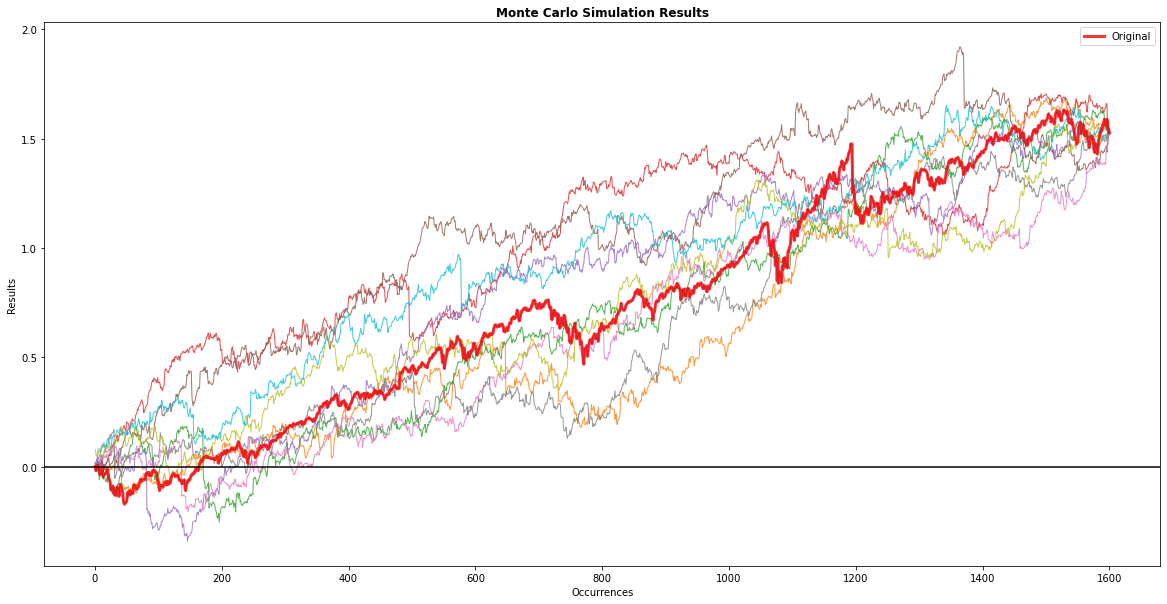

In [23]:
montecarlo_faangm = faangm_daily_returns['faangm'].montecarlo(sims=10, bust=-0.1, goal=1)
montecarlo_faangm.plot(figsize = (20, 10))